# 1. Description projet

**Liens du challenge :**

https://challengedata.ens.fr/participants/challenges/140/

**Contexte:**

Dans le cadre de l’activité de valorisation de l’énergie sur les marchés de l’électricité, Elmy aimerait disposer d’un modèle de prévision permettant de juger en amont si les prix de l’électricité sur le marché SPOT (marché d’enchère européen permettant d’acheter de l’électricité la veille pour le lendemain) seront plus ou moins élevés que les prix de l’électricité sur le marché Intraday (marché boursier européen permettant d’acheter de l’électricité le jour même).

**But:**

L’exercice consiste en la modélisation supervisée de l'écart de prix entre le marché infra-journalier (dit "Intraday") et le marché SPOT. L'écart de prix peut être modélisé par une régression mais aussi par une classification car ce qui importe avant tout est de prédire correctement le sens de cet écart (si tel ou tel prix sera supérieur ou inférieur à l’autre).

**Description des données:**

Index

*   *DELIVERY_START* : date et heure de livraison de l'électricité


Variables explicatives

* *load_forecast* : prévision de consommation totale d'éléctricité en France
* *coal_power_available*, *gas_power_available*, *nucelear_power_available* : capacité de production totale d'électricité des centrales à charbon, gaz et nucléaire respectivement,
* *wind_power_forecasts_average*, *solar_power_forecasts_average* : moyenne de différentes prévisions de production totale d'électricité éolienne et solaire (respectivement),
* *wind_power_forecasts_std*, *solar_power_forecasts_std* : écart-type de ces mêmes prévisions,
* *predicted_spot_price* : prévision du prix SPOT de l'électricité issues d'un modèle interne de Elmy. Ce modèle est lancé chaque jour avant la fermeture des enchères SPOT pour le lendemain.

Variable cible

* *spot_id_delta* : l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité (spot_id_delta = Intraday - SPOT) : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

**Description du benchmark**

Un benchmark simple consiste à prédire que les prix sur le marché Intraday sortiront toujours plus haut que les prix sur le marché SPOT. C'est à dire que les valeurs prédites seront toujours positives. On observe en effet que, historiquement, les prix sur le marché intraday sortent un peu plus souvent au dessus des prix au SPOT.

**Métrique d'évaluation des performances du modèle**

Puisque l'objectif est avant de tout de prédire correctement le sens de l'écart, on s'appuyera sur une métrique de classification pour évaluer la performance d'un modèle. La grandeur de l'écart observé nous importe aussi : plus l'écart observé est important, plus il est important de prédire le correctement son sens. La métrique de performance proposée pour ce challenge est donc la Weighted Accuracy. C'est à dire la proprotion des predictions dont les sens (positif ou négatif) est correctement identifié pondérée par la valeur absolue des écarts réellement observés.

# 2. Données

## 2.1 Importation données

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
# Chemin de base pour tous vos fichiers de données
folder_path = 'https://raw.githubusercontent.com/Austin-Mo/Projet_ML/main/datas'

# Chemins spécifiques vers les fichiers en utilisant folder_path
path_train = f'{folder_path}/X_train.csv'
path_test = f'{folder_path}/X_test.csv'
path_y_train = f'{folder_path}/y_train.csv'
path_y_random = f'{folder_path}/y_random.csv'

In [3]:
# Chargement des données
def parse_dates(date):
    return pd.to_datetime(date).date()

# Chargement des données en spécifiant directement l'index et la conversion datetime
X_train = pd.read_csv(path_train, index_col='DELIVERY_START', parse_dates=['DELIVERY_START'])
X_test = pd.read_csv(path_test, index_col='DELIVERY_START', parse_dates=['DELIVERY_START'])
y_train = pd.read_csv(path_y_train, index_col='DELIVERY_START', parse_dates=['DELIVERY_START'])
y_test= pd.read_csv(path_y_random, index_col='DELIVERY_START', parse_dates=['DELIVERY_START'])

In [4]:
# Afficher les statistiques descriptives pour X_train
X_train.describe()


,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
count,9318.000000,10604.000000,10604.000000,10604.000000,10581.000000,10581.000000,10581.000000,10581.000000,1846.000000
mean,53725.132968,2819.781592,11463.220671,35393.282252,4512.989415,1919.281353,125.399422,24.997384,140.256024
std,11274.194929,495.103588,483.799154,7619.820162,3349.419356,2706.963383,132.152875,43.083977,33.922669
min,30515.000000,1646.000000,9769.000000,22285.000000,592.000000,0.000000,1.830211,0.000000,42.420000
25%,45336.500000,2226.000000,11140.000000,29005.000000,2036.000000,0.000000,46.818974,0.000000,119.405000
50%,51846.000000,2806.000000,11487.000000,32470.000000,3319.000000,149.000000,86.700163,3.507229,140.040000
75%,62091.750000,3386.000000,11945.000000,43055.000000,5951.000000,3507.000000,155.325644,35.137019,160.765000
max,85145.000000,3391.000000,11963.000000,50122.000000,15167.000000,10127.000000,1871.571992,745.261316,254.190000


In [5]:
X_train.head()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
DELIVERY_START,,,,,,,,,
2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN
2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN
2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN
2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN
2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN


In [6]:
y_train.head()

,spot_id_delta
DELIVERY_START,
2022-01-01 02:00:00+01:00,-36.874770
2022-01-01 03:00:00+01:00,-12.643588
2022-01-01 04:00:00+01:00,-1.950193
2022-01-01 05:00:00+01:00,1.938272
2022-01-01 06:00:00+01:00,0.199907


## 2.2 Analyse données

* ### Variable expliquée 

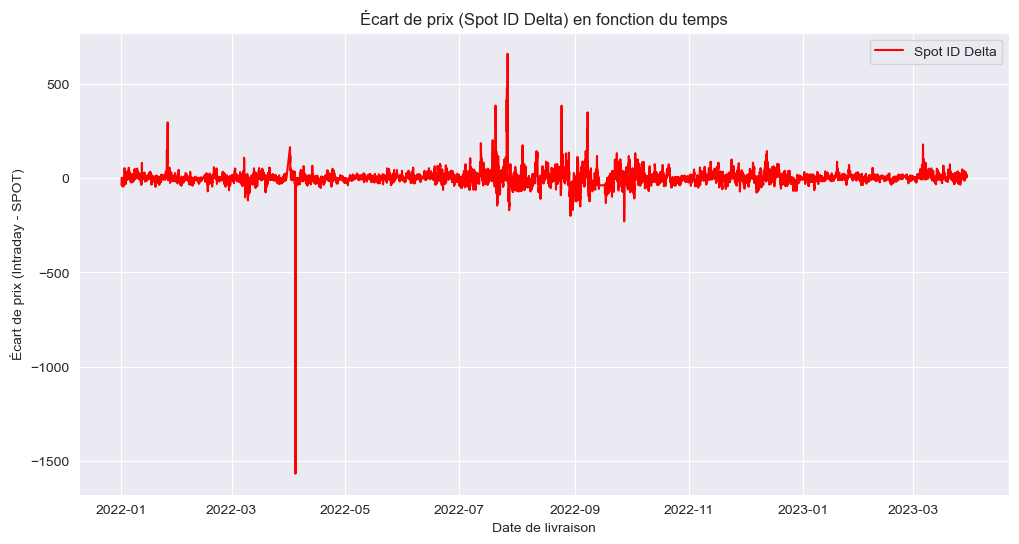

In [7]:
# Créer le graphique
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train['spot_id_delta'], label='Spot ID Delta', color='red')
plt.title('Écart de prix (Spot ID Delta) en fonction du temps')
plt.xlabel('Date de livraison')
plt.ylabel('Écart de prix (Intraday - SPOT)')
plt.legend()
plt.grid(True)

plt.show()

In [8]:
# On retire les valeurs extrêmes 1% de y_train
'''y_lower_bound = y_train['spot_id_delta'].quantile(0.01)
y_upper_bound = y_train['spot_id_delta'].quantile(0.99)
outlier_mask = (y_train['spot_id_delta'] > y_lower_bound) & (y_train['spot_id_delta'] < y_upper_bound)

# Appliquer le masque à y_train et X_train
y_train = y_train[outlier_mask]
X_train = X_train[outlier_mask]'''

"y_lower_bound = y_train['spot_id_delta'].quantile(0.01)\ny_upper_bound = y_train['spot_id_delta'].quantile(0.99)\noutlier_mask = (y_train['spot_id_delta'] > y_lower_bound) & (y_train['spot_id_delta'] < y_upper_bound)\n\n# Appliquer le masque à y_train et X_train\ny_train = y_train[outlier_mask]\nX_train = X_train[outlier_mask]"

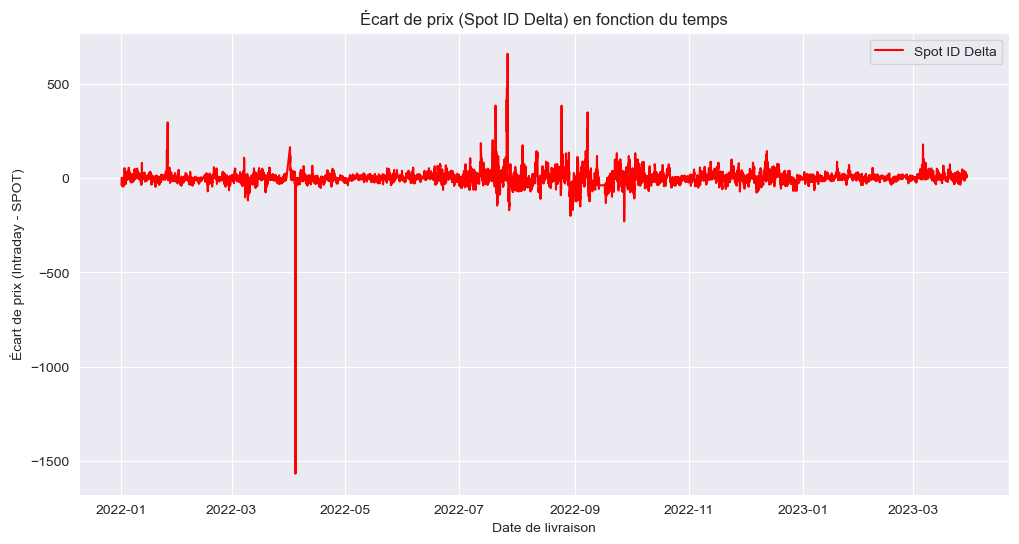

In [9]:
# Créer le graphique
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train['spot_id_delta'], label='Spot ID Delta', color='red')
plt.title('Écart de prix (Spot ID Delta) en fonction du temps')
plt.xlabel('Date de livraison')
plt.ylabel('Écart de prix (Intraday - SPOT)')
plt.legend()
plt.grid(True)

plt.show()

Valeur maximale de spot_id_delta: 658.9613293687667
Valeur minimale de spot_id_delta: -1567.35354675402


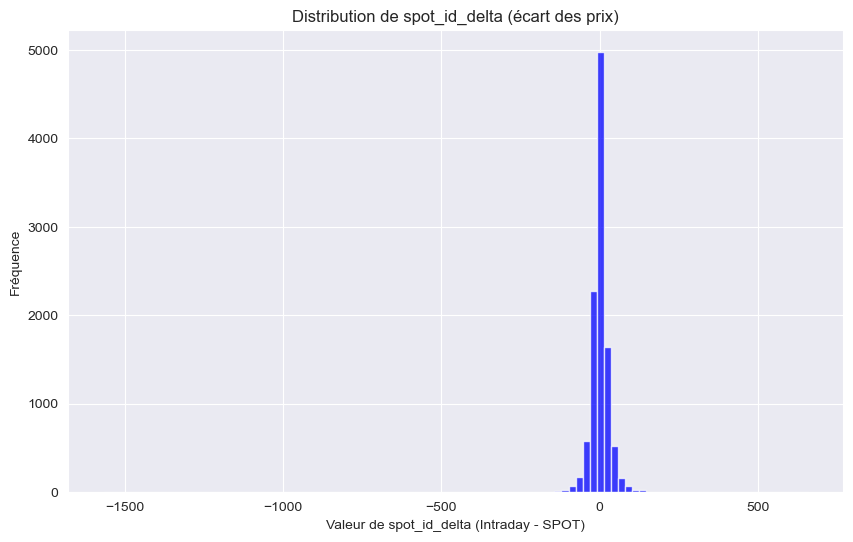

In [10]:
# Affichage de la valeur maximale dans y_train pour la colonne 'spot_id_delta'
print("Valeur maximale de spot_id_delta:", y_train['spot_id_delta'].max())

# Affichage de la valeur minimale dans y_train pour la colonne 'spot_id_delta'
print("Valeur minimale de spot_id_delta:", y_train['spot_id_delta'].min())

# Histogramme de spot_id_delta
plt.figure(figsize=(10, 6))
plt.hist(y_train['spot_id_delta'], bins=100, alpha=0.75, color='blue')
plt.title('Distribution de spot_id_delta (écart des prix)')
plt.xlabel('Valeur de spot_id_delta (Intraday - SPOT)')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

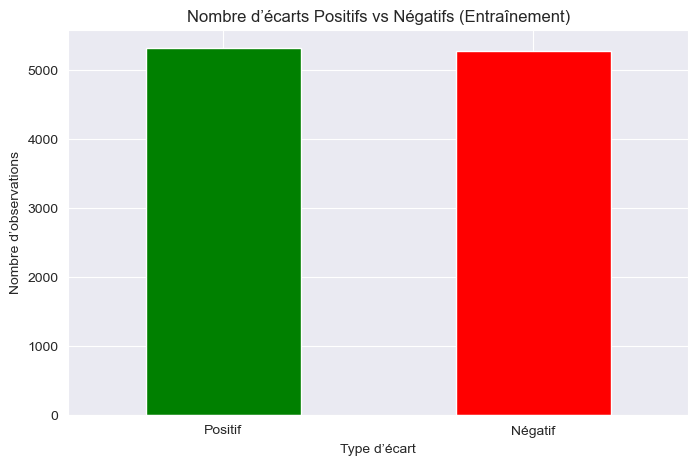

Entraînement - Nombre d'écarts positifs: 5320
Entraînement - Nombre d'écarts négatifs: 5285


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Création de DataFrames pour les écarts
ecarts_train = pd.DataFrame({
    'Écart': y_train['spot_id_delta'],
    'Type': ['Positif' if x > 0 else 'Négatif' for x in y_train['spot_id_delta']]
})
# Fonction pour visualiser les écarts
def plot_ecarts(df, title):
    counts = df['Type'].value_counts()
    plt.figure(figsize=(8, 5))
    counts.plot(kind='bar', color=['green', 'red'])
    plt.title(f'Nombre d’écarts Positifs vs Négatifs ({title})')
    plt.xlabel('Type d’écart')
    plt.ylabel('Nombre d’observations')
    plt.xticks(rotation=0)
    plt.show()
    print(f"{title} - Nombre d'écarts positifs:", counts.get('Positif', 0))
    print(f"{title} - Nombre d'écarts négatifs:", counts.get('Négatif', 0))

# Appel de la fonction pour les données d'entraînement et de test
plot_ecarts(ecarts_train, 'Entraînement')

* ###  Variables explicatives

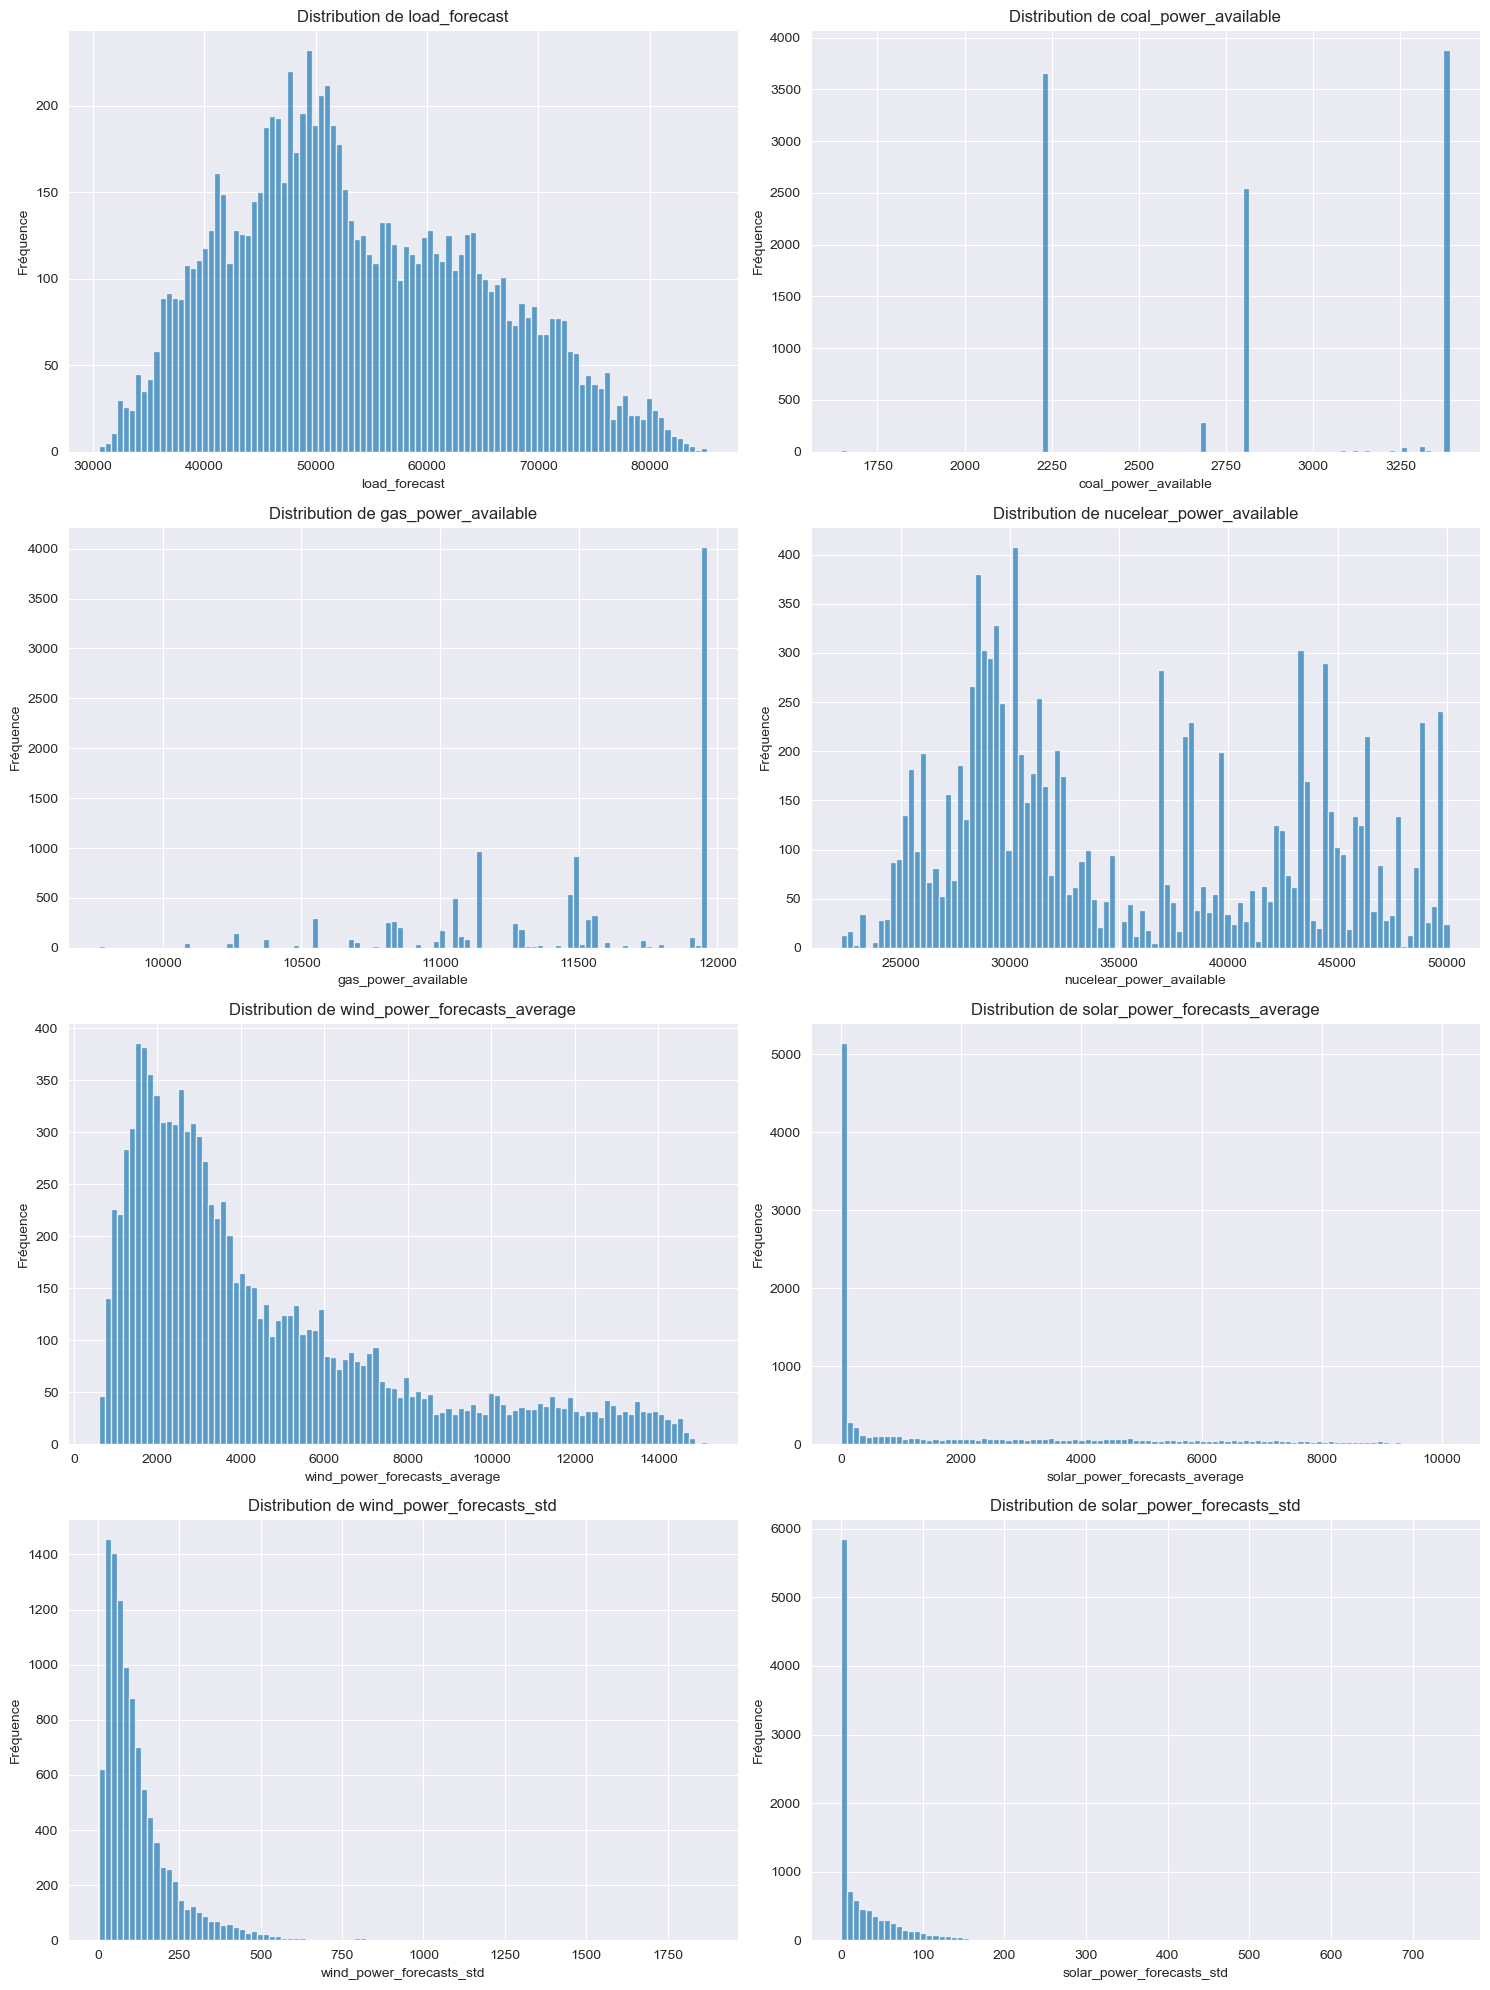

In [12]:
numeric_vars = ['load_forecast', 'coal_power_available', 'gas_power_available', 
                'nucelear_power_available', 'wind_power_forecasts_average', 
                'solar_power_forecasts_average', 'wind_power_forecasts_std', 
                'solar_power_forecasts_std']

# Nombre de variables pour déterminer le nombre de sous-graphiques nécessaires
num_vars = len(numeric_vars)
num_rows = (num_vars + 1) // 2  # Calculer le nombre de lignes nécessaires

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5 * num_rows))  # Ajuster la taille totale de la figure

for i, var in enumerate(numeric_vars):
    ax = axes[i//2, i%2]  # Déterminer la position du sous-graphique
    ax.hist(X_train[var].dropna(), bins=100, alpha=0.7)
    ax.set_title(f'Distribution de {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Fréquence')

# Ajuster les graphiques pour qu'ils ne se chevauchent pas
plt.tight_layout()
plt.show()


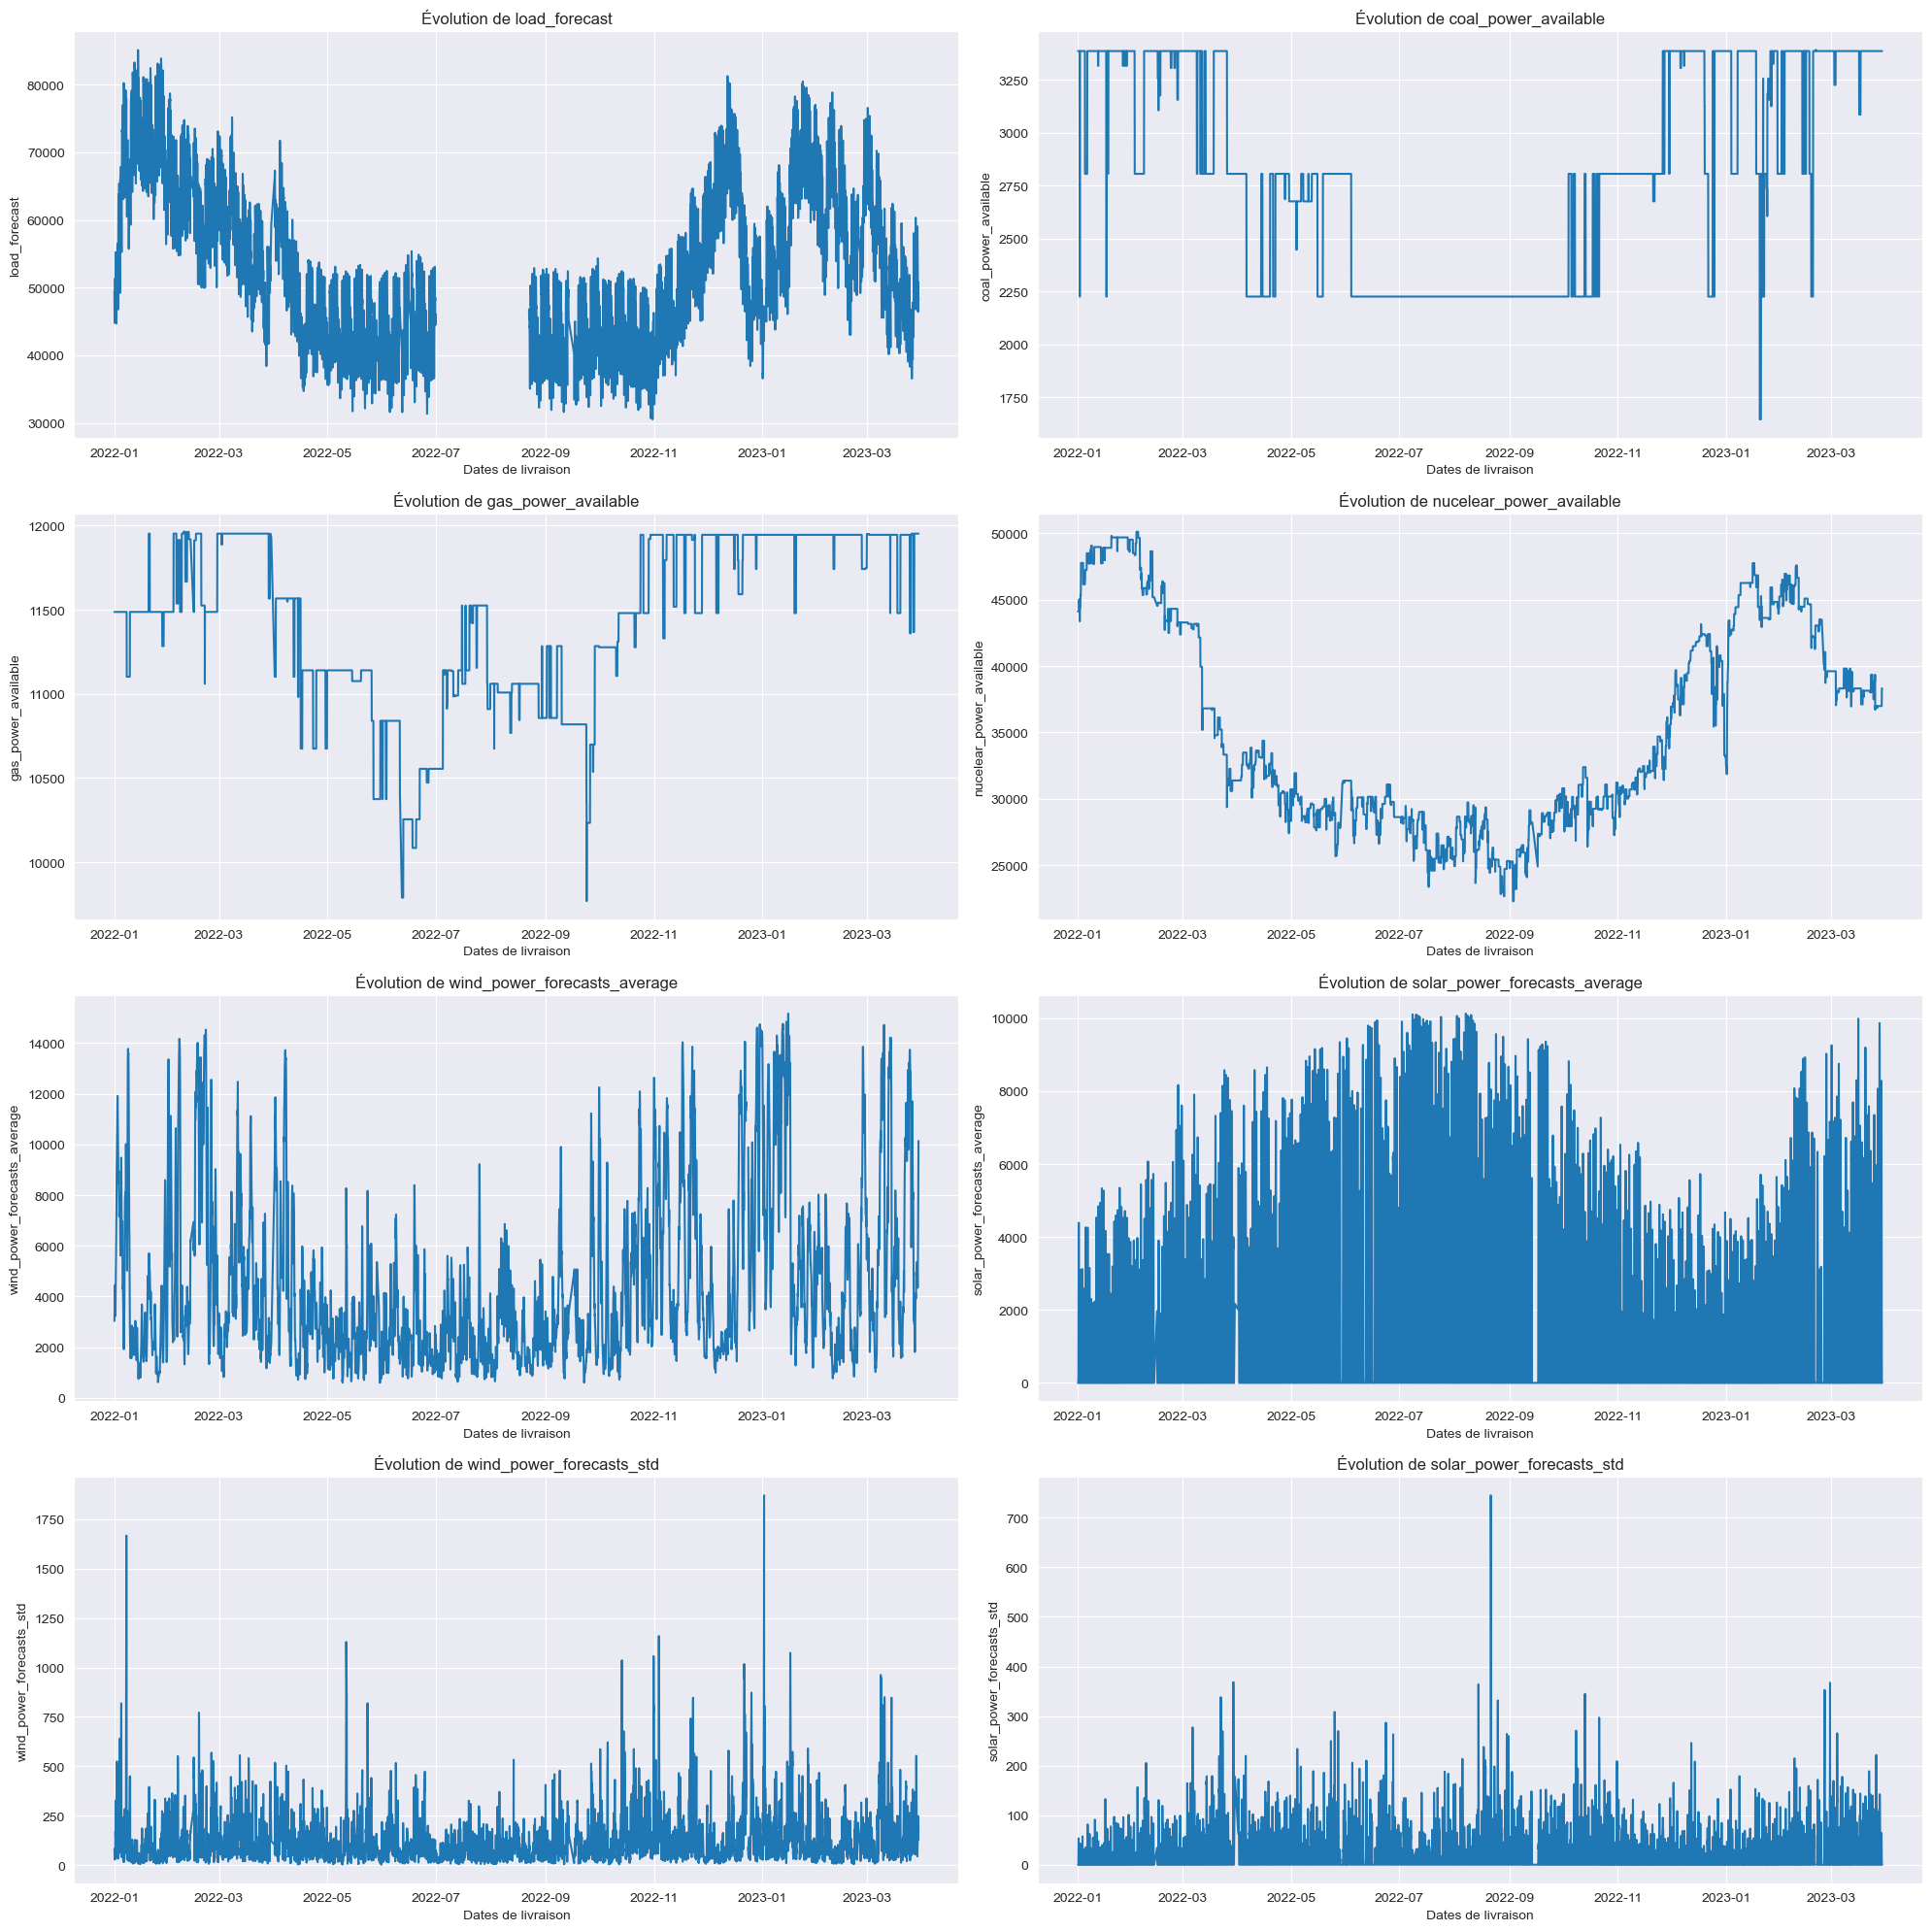

In [13]:
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 5 * num_rows)) 
for i, var in enumerate(numeric_vars):
    ax = axes[i // 2, i % 2]  # Déterminer la position du sous-graphique
    ax.plot(X_train.index, X_train[var], marker='', linestyle='-', label=var)
    ax.set_title(f'Évolution de {var}')
    ax.set_xlabel('Dates de livraison')
    ax.set_ylabel(var)
    ax.grid(True)

# Ajuster les graphiques pour qu'ils ne se chevauchent pas
plt.tight_layout()
plt.show()

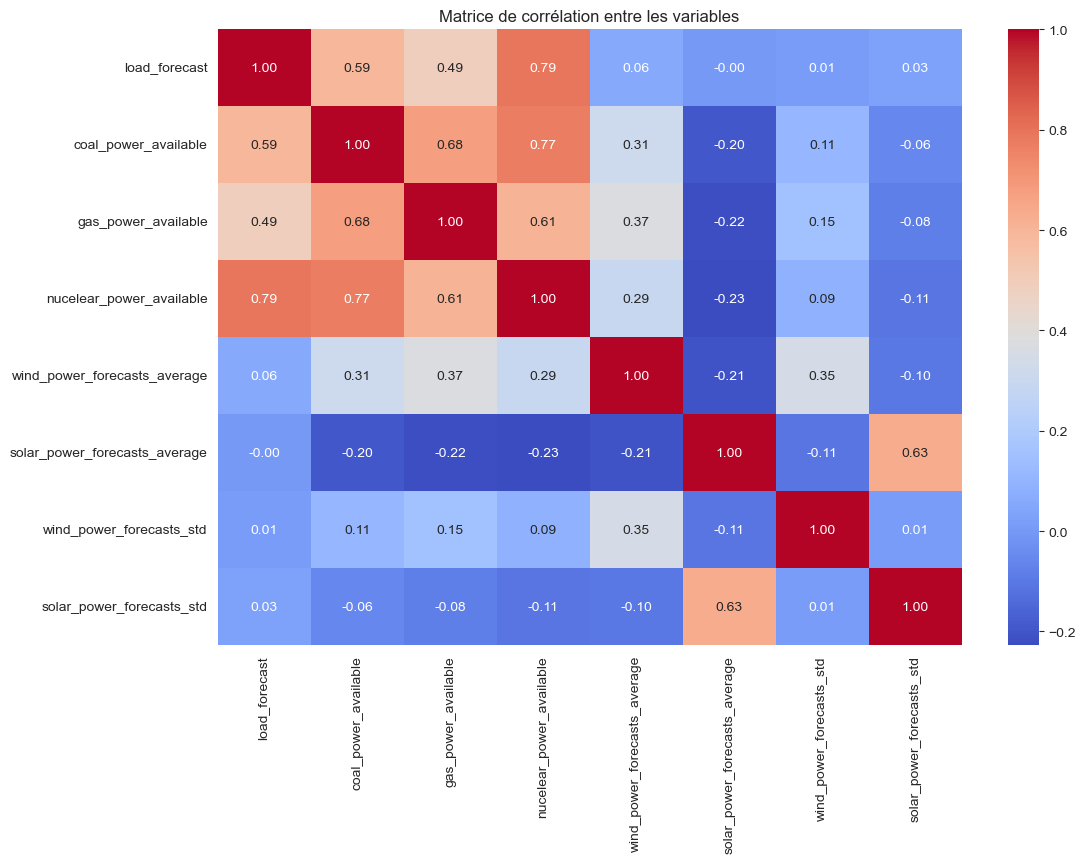

In [14]:
# Matrice de corrélation
corr_matrix = X_train[numeric_vars].corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation entre les variables')
plt.show()


## 2.3 Prétraitement des données

<Axes: >

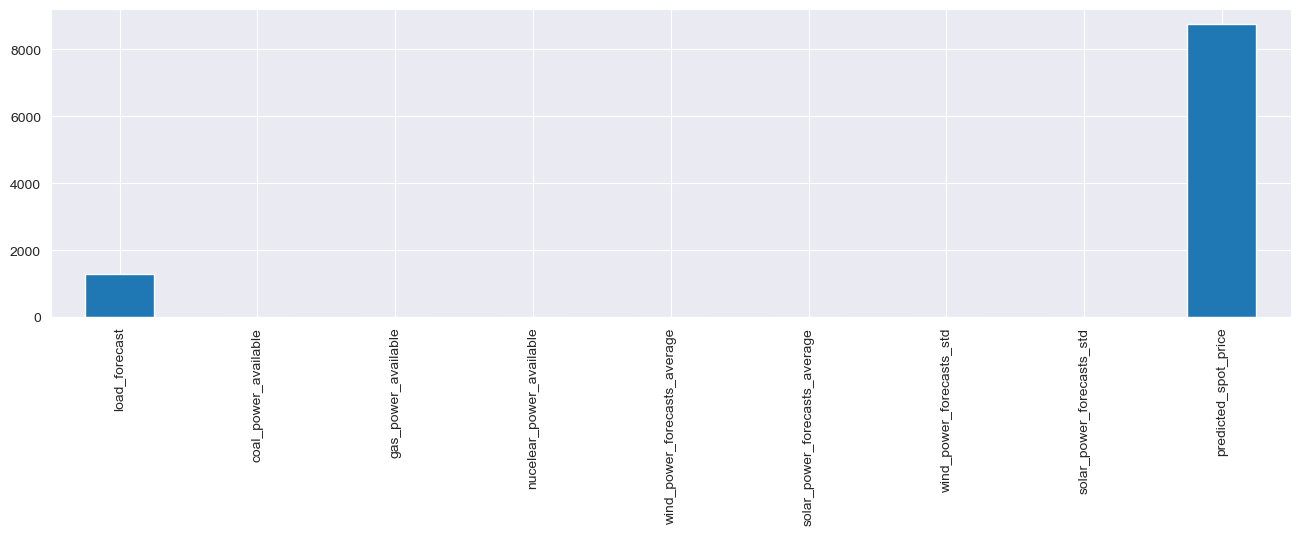

In [15]:
# insert your code here
plt.figure(figsize=(16,4))
(len(X_train.index)-X_train.count()).plot.bar()

In [16]:
# Check du nombre de valeurs manquantes par colonnes
X_train.isnull().sum()

load_forecast                    1287
coal_power_available                1
gas_power_available                 1
nucelear_power_available            1
wind_power_forecasts_average       24
solar_power_forecasts_average      24
wind_power_forecasts_std           24
solar_power_forecasts_std          24
predicted_spot_price             8759
dtype: int64

In [17]:
X_test = X_test.drop(['predicted_spot_price'], axis = 1)
X_train = X_train.drop(['predicted_spot_price'], axis = 1)

In [18]:
from sklearn.impute import KNNImputer

# Imputation des valeurs manquantes par KNN
imputer = KNNImputer(n_neighbors=5)
X_train_transform = imputer.fit_transform(X_train)
X_test_transform = imputer.transform(X_test)

In [19]:
# Imputation de la moyenne pour les valeurs manquantes
'''imputer = SimpleImputer(strategy='mean')
X_train_transform = imputer.fit_transform(X_train)
X_test_transform = imputer.transform(X_test)'''

"imputer = SimpleImputer(strategy='mean')\nX_train_transform = imputer.fit_transform(X_train)\nX_test_transform = imputer.transform(X_test)"

* fit : Calcule la moyenne (mean) de chaque colonne pour remplir les valeurs manquantes.
* transform : Applique la transformation aux données en utilisant les paramètres calculés.

In [20]:
# Normalisation des données pour toutes les colonnes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transform)
X_test_scaled = scaler.transform(X_test_transform)

* **fit** : Calcule la moyenne (mean) et l'écart type (std) de chaque colonne.
* **transform** :il soustraira la moyenne et divisera par l'écart type pour chaque caractéristique afin de normaliser les données.

**Important**: nous n'utilisons pas fit_transform() sur les données de test, car cela entraînerait un recalcul des paramètres du modèle qui pourrait conduire à un biais ou un surajustement.

In [21]:
# Convertir les données normalisées en DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

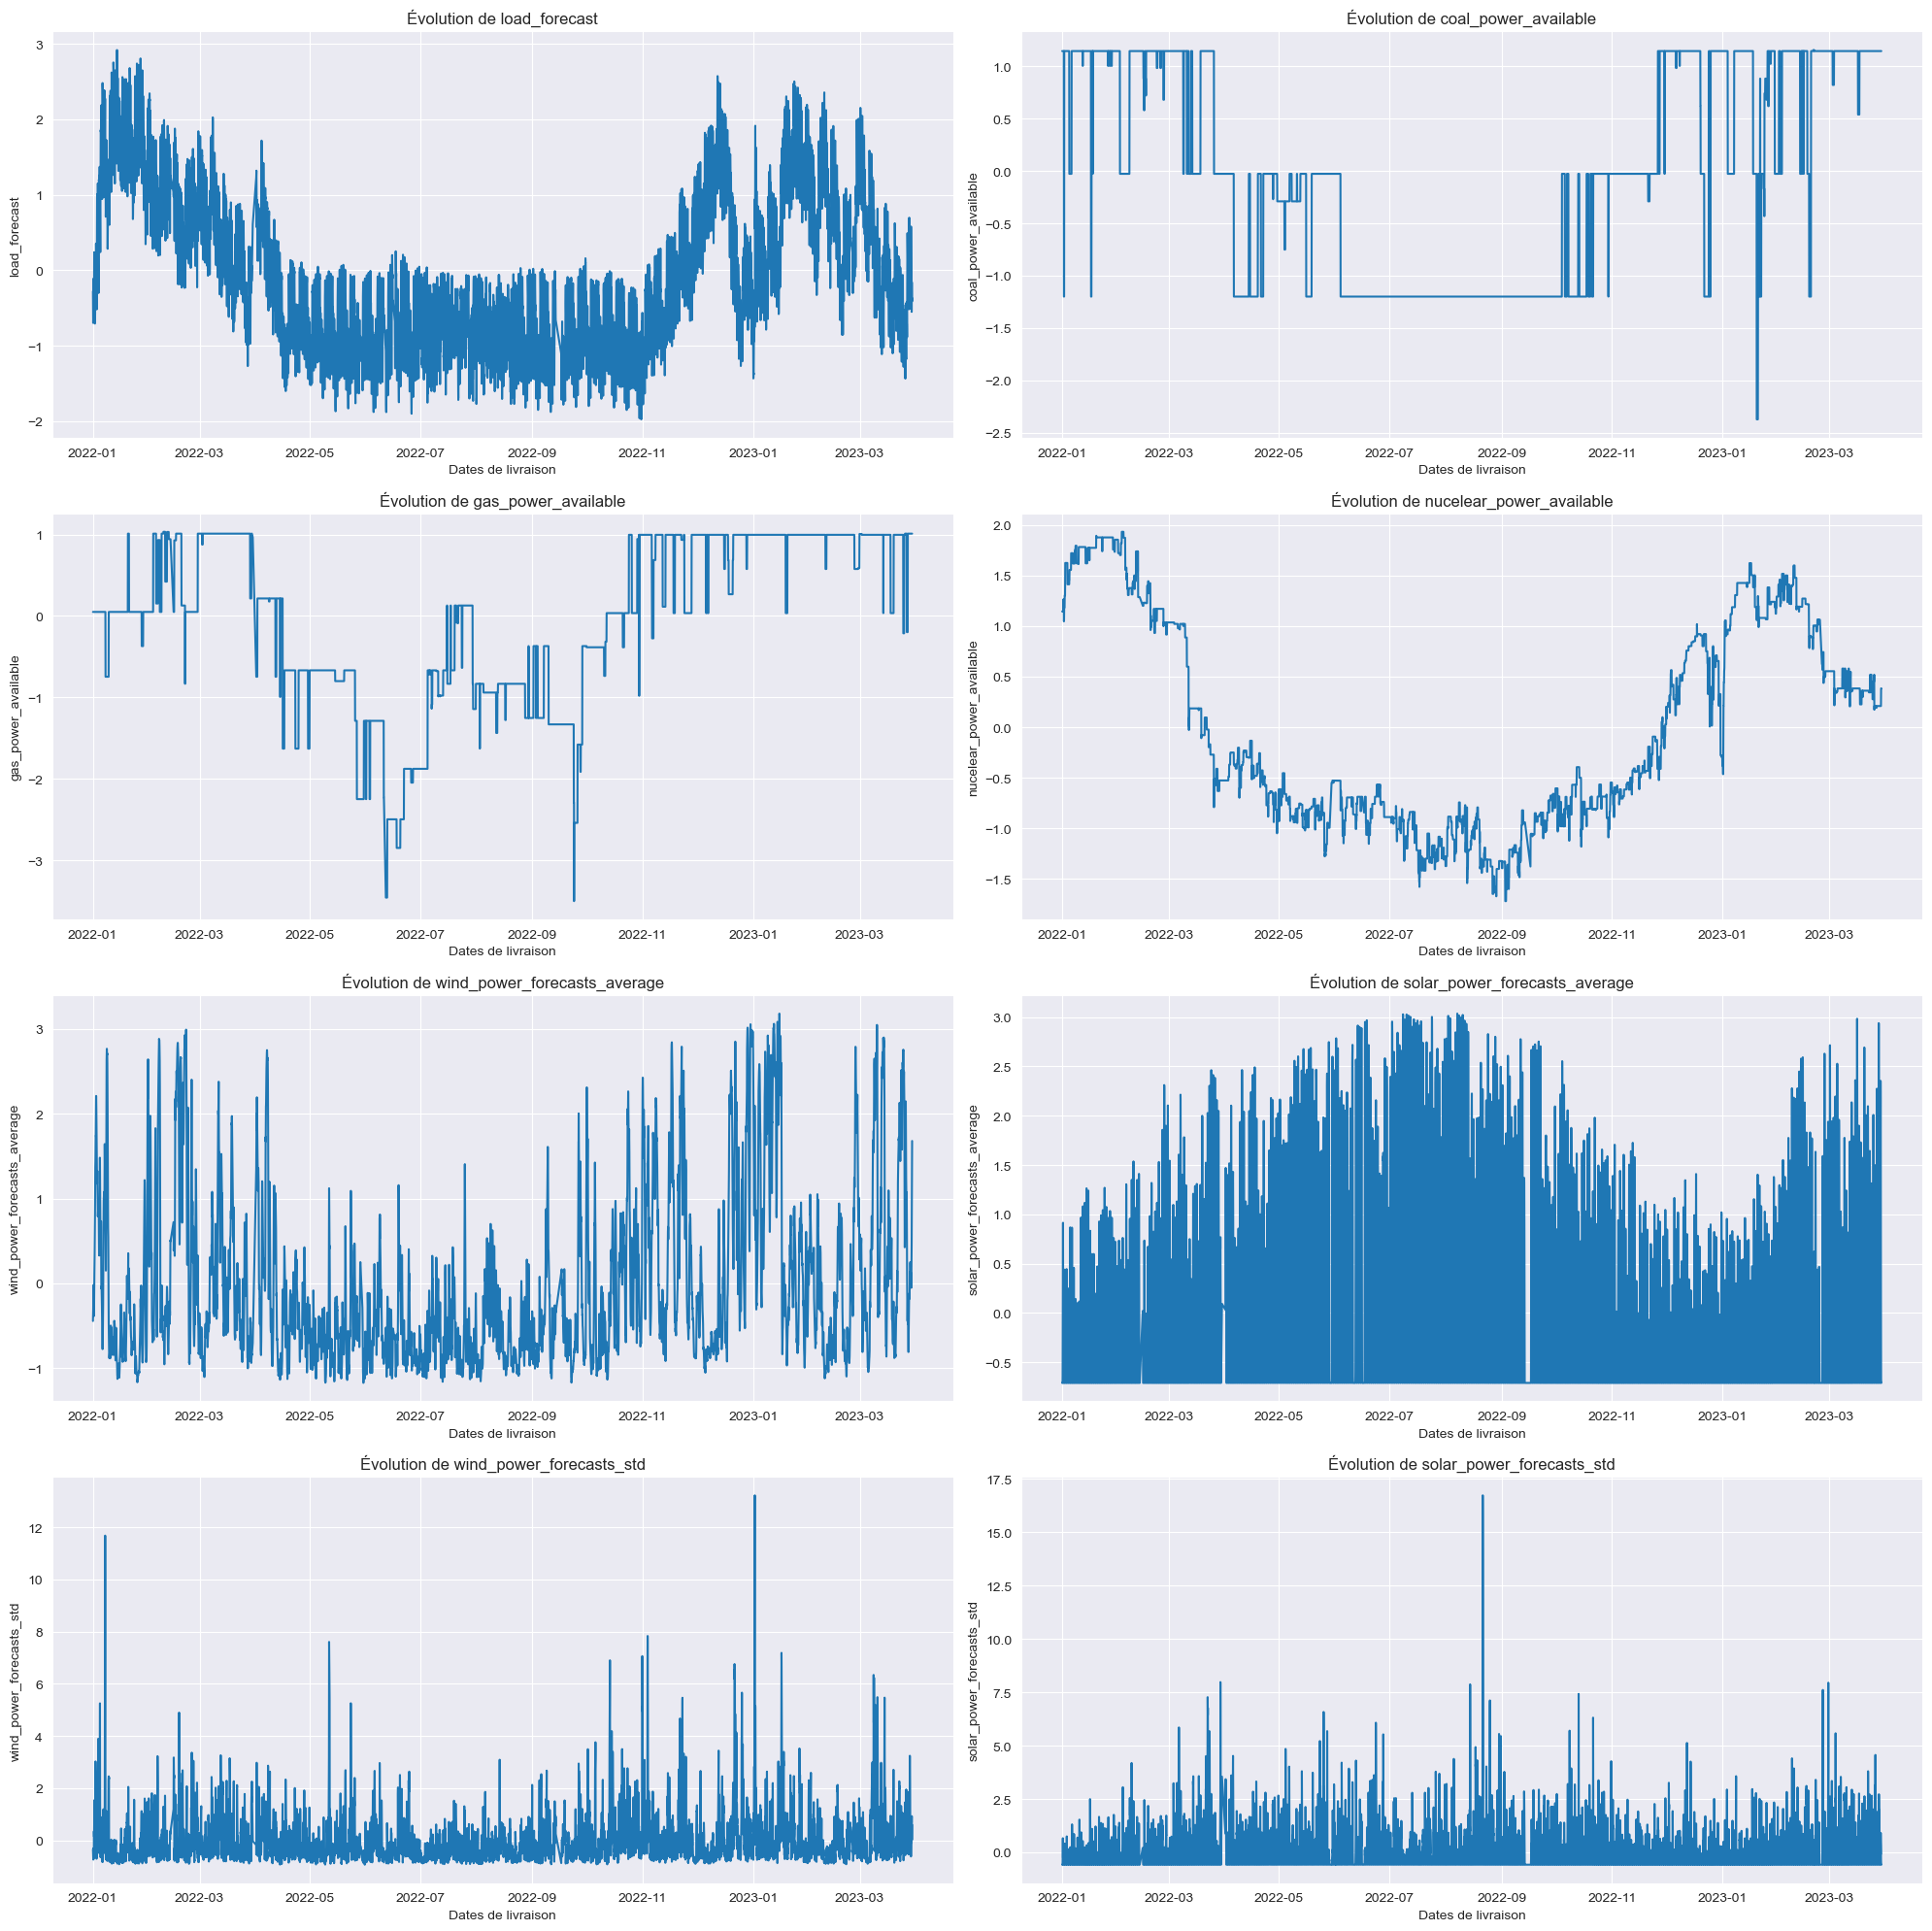

In [22]:
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 5 * num_rows)) 
for i, var in enumerate(numeric_vars):
    ax = axes[i // 2, i % 2]  # Déterminer la position du sous-graphique
    ax.plot(X_train.index, X_train[var], marker='', linestyle='-', label=var)
    ax.set_title(f'Évolution de {var}')
    ax.set_xlabel('Dates de livraison')
    ax.set_ylabel(var)
    ax.grid(True)

# Ajuster les graphiques pour qu'ils ne se chevauchent pas
plt.tight_layout()
plt.show()

In [23]:
# Ajouter les mois
X_train.index = pd.to_datetime(X_train.index, utc=True)
X_train['month'] = X_train.index.month

X_test.index = pd.to_datetime(X_test.index, utc=True)
X_test['month'] = X_test.index.month

# Définition de la fonction pour mapper les mois aux saisons
def get_season(month):
    if month in [12, 1, 2]:
        return '0' # Winter
    elif month in [3, 4, 5]:
        return '1' # Spring
    elif month in [6, 7, 8]:
        return '2' # Summer
    elif month in [9, 10, 11]:
        return '3' # Fall

# Application de la fonction pour créer la colonne 'season'
X_train['season'] = X_train['month'].apply(get_season)
X_test['season'] = X_test['month'].apply(get_season)

# Affichage des premières lignes pour vérifier
print(X_train.head())

                           load_forecast  coal_power_available  \
DELIVERY_START                                                   
2022-01-01 01:00:00+00:00      -0.280667               1.14378   
2022-01-01 02:00:00+00:00      -0.542878               1.14378   
2022-01-01 03:00:00+00:00      -0.664044               1.14378   
2022-01-01 04:00:00+00:00      -0.697984               1.14378   
2022-01-01 05:00:00+00:00      -0.652760               1.14378   

                           gas_power_available  nucelear_power_available  \
DELIVERY_START                                                             
2022-01-01 01:00:00+00:00             0.049246                   1.14515   
2022-01-01 02:00:00+00:00             0.049246                   1.14515   
2022-01-01 03:00:00+00:00             0.049246                   1.14515   
2022-01-01 04:00:00+00:00             0.049246                   1.14515   
2022-01-01 05:00:00+00:00             0.049246                   1.14515   

    

# 3. Modèles

## 3.1 Linéaire

* ### Regréssion linéaire

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Dictionnaire pour stocker les RMSE de chaque modèle
model_rmse = {}

# Modèle de régression linéaire
linear_model = LinearRegression()

# Utiliser KFold pour la validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculer les scores de validation croisée pour LinearRegression
linear_cv_scores = cross_val_score(linear_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Convertir les scores négatifs en positifs pour obtenir les RMSE
linear_rmse_scores = np.sqrt(-linear_cv_scores)

print("Cross-validated RMSE scores (Linear Regression):", linear_rmse_scores)

# Entraîner le modèle sur l'ensemble complet d'entraînement
linear_model.fit(X_train, y_train)

# Prédiction et évaluation sur l'ensemble de test
y_pred_linear = linear_model.predict(X_test)
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)

print("Test RMSE (Linear Regression):", rmse_linear)

model_rmse['Linear Regression'] = rmse_linear

Cross-validated RMSE scores (Linear Regression): [31.69022568 46.43923704 29.92383205 32.41179361 46.19443095]
Test RMSE (Linear Regression): 13.711131619194266


* ### Régression Ridge

La régression Ridge est une technique de régression linéaire régularisée qui peut nous permettre de prévenir le surajustement en ajoutant un terme de pénalité à la fonction de coût.

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Définition de la grille de paramètres
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0]
}

# Création du modèle Ridge
ridge_model = Ridge()

# Configuration de GridSearchCV
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

# Entraînement de GridSearchCV
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_ridge_model = grid_search.best_estimator_

# Prédiction avec le meilleur modèle
y_pred_ridge = best_ridge_model.predict(X_test)

# Évaluation du meilleur modèle
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
print("Best RMSE (Ridge Regression):", rmse_ridge)
print("Best alpha:", grid_search.best_params_['alpha'])

# Stockage du RMSE dans le dictionnaire
model_rmse['Ridge Regression'] = rmse_ridge

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best RMSE (Ridge Regression): 13.18186386095394
Best alpha: 500.0


* ### Régression Lasso

La régression Lasso est similaire à la régression Ridge, mais elle peut nous permettre de pousser certains coefficients de caractéristiques à exactement zéro.

In [26]:
from sklearn.linear_model import Lasso

# Définition de la grille de paramètres pour Lasso
param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Création du modèle Lasso
lasso_model = Lasso()

# Configuration de GridSearchCV
grid_search_lasso = GridSearchCV(estimator=lasso_model, param_grid=param_grid_lasso, scoring='neg_mean_squared_error', cv=5, verbose=1)

# Entraînement de GridSearchCV
grid_search_lasso.fit(X_train, y_train)

# Meilleur modèle
best_lasso_model = grid_search_lasso.best_estimator_

# Prédiction avec le meilleur modèle
y_pred_lasso = best_lasso_model.predict(X_test)

# Évaluation du meilleur modèle
# Utilisation de la fonction rmse_score définie précédemment pour calculer le RMSE
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
print("Best RMSE (Lasso Regression):", rmse_lasso)
print("Best alpha:", grid_search_lasso.best_params_['alpha'])

# Stockage du RMSE dans le dictionnaire
model_rmse['Lasso Regression'] = rmse_lasso

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best RMSE (Lasso Regression): 12.150878473295773
Best alpha: 10


## 3.2 Méthode ensembliste

* ###  Forêt Aléatoire

Les forêts aléatoires sont des ensembles de plusieurs arbres de décision, qui peut nous aider à réduire le risque de surajustement des modèles d'arbres uniques.

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Définir si le GridSearchCV doit être exécuté
perform_grid_search = False  # Changez cette valeur pour contrôler l'exécution du GridSearch

# Création du modèle RandomForest
rf_model = RandomForestRegressor(random_state=42)

if perform_grid_search:
    # Définition de la grille de paramètres pour GridSearchCV
    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Configuration de GridSearchCV
    grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                                  scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

    # Entraînement de GridSearchCV
    grid_search_rf.fit(X_train, y_train)

    # Meilleur modèle
    best_rf_model = grid_search_rf.best_estimator_
     # Imprimer les meilleurs paramètres
    print("Best parameters from GridSearchCV:", grid_search_rf.best_params_)
else:
     # Utilisation des paramètres find with the first GridSearch
    best_rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, max_features='sqrt', 
                                          min_samples_leaf=4, min_samples_split=2, random_state=42)
    best_rf_model.fit(X_train, y_train)

# Prédiction avec le meilleur modèle
y_pred_rf = best_rf_model.predict(X_test)

# Évaluation du modèle
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print("Optimized RMSE (Random Forest):", rmse_rf)

# Stocker le RMSE dans le dictionnaire
model_rmse['Random Forest'] = rmse_rf


C:\Users\morel\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Optimized RMSE (Random Forest): 12.99334478682523


* ###  Gradient Boosting

Le Gradient Boosting est une autre technique d'ensemble puissante pour les tâches de régression et de classification.

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

# Création et entraînement du modèle
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Prédiction sur le set de test
y_pred_gb = gb_model.predict(X_test)

# Évaluation du modèle
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
print("RMSE (Gradient Boosting):", rmse_gb)

model_rmse['Gradient Boosting'] = rmse_gb


C:\Users\morel\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE (Gradient Boosting): 15.028724999121442


In [29]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Définir si le GridSearchCV doit être exécuté
perform_grid_search = False # Changez cette valeur pour contrôler l'exécution du GridSearch

# Création du modèle GradientBoosting avec des paramètres prédéfinis
if perform_grid_search:
    # Définition de la grille de paramètres pour GridSearchCV
    param_grid_gb = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 3, 5]
    }

    # Configuration de GridSearchCV
    grid_search_gb = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                                  param_grid=param_grid_gb,
                                  scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

    # Entraînement de GridSearchCV
    grid_search_gb.fit(X_train, y_train)

    # Utilisation du meilleur modèle trouvé par GridSearch
    best_gb_model = grid_search_gb.best_estimator_

     # Imprimer les meilleurs paramètres
    print("Best parameters from GridSearchCV:", grid_search_gb.best_params_)
    
else:
    # Utilisation des paramètres find with the first GridSearch
    best_gb_model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.01, max_depth=3,
                                              min_samples_split=2, min_samples_leaf=3, random_state=42)
    best_gb_model.fit(X_train, y_train)

# Prédiction avec le meilleur modèle
y_pred_gb = best_gb_model.predict(X_test)

# Évaluation du modèle
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
print("Optimized RMSE (Gradient Boosting):", rmse_gb)

# Si besoin, stocker le RMSE dans un dictionnaire pour comparaison
model_rmse['Gradient Boosting'] = rmse_gb


C:\Users\morel\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimized RMSE (Gradient Boosting): 12.142395283069305


* ###  Bagging

In [30]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Création du modèle de base
base_estimator = DecisionTreeRegressor()

# Création et entraînement du modèle Bagging
bagging_model = BaggingRegressor(base_estimator, n_estimators=100, random_state=42)
bagging_model.fit(X_train, y_train)

# Prédiction sur le set de test
y_pred_bagging = bagging_model.predict(X_test)

# Évaluation du modèle
rmse_bagging = mean_squared_error(y_test, y_pred_bagging, squared=False)
print("RMSE (Bagging):", rmse_bagging)

model_rmse['Bagging'] = rmse_bagging

C:\Users\morel\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:509: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


RMSE (Bagging): 14.623137964679863


* ###  Stacking

In [31]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso

# Définir les modèles de base avec les paramètres ajustés
estimators = [
    ('Lasso', Lasso()),  # Paramètre optimisé pour Lasso
    ('gradient_boosting', GradientBoostingRegressor(
        n_estimators=100,  # Nombre réduit d'estimateurs
        random_state=42  # Pour la reproductibilité
    ))
]

# Estimateur final avec les paramètres ajustés
final_estimator = GradientBoostingRegressor(
    n_estimators=100,  # Nombre d'estimateurs pour l'estimateur final
    random_state=42  # Pour la reproductibilité
)

# Création et entraînement du modèle Stacking
stacking_model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
stacking_model.fit(X_train, y_train)

# Prédiction sur le set de test
y_pred_stacking = stacking_model.predict(X_test)

# Évaluation du modèle
rmse_stacking = mean_squared_error(y_test, y_pred_stacking, squared=False)
print("RMSE (Stacking):", rmse_stacking)

# Stocker le RMSE dans un dictionnaire pour comparaison
model_rmse['Stacking'] = rmse_stacking

C:\Users\morel\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:955: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE (Stacking): 12.013561223084071


In [32]:
rmse_df = pd.DataFrame(list(model_rmse.items()), columns=['Model', 'RMSE'])
rmse_df

,Model,RMSE
0,Linear Regression,13.711132
1,Ridge Regression,13.181864
2,Lasso Regression,12.150878
3,Random Forest,12.993345
4,Gradient Boosting,12.142395
5,Bagging,14.623138
6,Stacking,12.013561


In [33]:
#Grouper les prédictions y_pred des modèles dans un dataframe

y_pred_df = pd.DataFrame({
    'y_test': y_test.values.flatten(),
    'Linear Regression': y_pred_linear.ravel(),
    'Ridge Regression': y_pred_ridge.ravel(),
    'Lasso Regression': y_pred_lasso.ravel(),
    'Random Forest': y_pred_rf.ravel(),
    'Gradient Boosting': y_pred_gb.ravel(),
    'Bagging': y_pred_bagging.ravel(),
    'Stacking': y_pred_stacking.ravel()
})

y_pred_df

,y_test,Linear Regression,Ridge Regression,Lasso Regression,Random Forest,Gradient Boosting,Bagging,Stacking
0,9.425522,0.951405,0.755762,0.943358,-0.345353,0.690142,-0.684081,-4.665655
1,21.462587,0.466796,0.357582,0.943358,-0.540511,0.690142,-1.064489,-4.665655
2,6.629638,0.324490,0.254309,0.943358,-0.809147,0.690142,-0.902934,-4.665655
3,13.770136,-0.343149,-0.290390,0.943358,-1.363082,0.690142,-1.136767,-0.347588
4,3.398464,-0.728929,-0.594683,0.943358,-1.223148,0.690142,1.055472,-0.347588
...,...,...,...,...,...,...,...,...
4937,-0.956116,-2.085616,-0.836898,0.943358,-1.002575,0.936859,0.525436,3.342658
4938,-0.210950,-0.958283,0.091092,0.943358,-1.082354,0.936859,-1.174455,3.679699
4939,-5.465262,-1.437160,-0.259351,0.943358,1.765519,0.936859,1.544878,1.653109
4940,24.714457,-2.178018,-0.820348,0.943358,1.631081,0.936859,0.305005,2.672118


In [34]:
import pandas as pd
import numpy as np

# Supposons que y_test et y_pred_rf sont déjà définis comme des numpy arrays ou des pandas Series
y_true = np.array(y_test)  # Assurez-vous que ce sont des arrays
y_pred = np.array(y_pred_stacking)

# Création de la DataFrame
df = pd.DataFrame({
    'Actual': y_true.flatten(),  # Aplatir en cas de multi-dimension
    'Predicted': y_pred.flatten()
})

# Calcul des signes
df['Actual_Sign'] = np.sign(df['Actual'])
df['Predicted_Sign'] = np.sign(df['Predicted'])

# Concordance des signes
df['Same_Sign'] = df['Actual_Sign'] == df['Predicted_Sign']

same_sign_proportion = df['Same_Sign'].mean()  # mean() sur une colonne booléenne donne la proportion de True
print("Proportion de cas avec des signes identiques :", same_sign_proportion)

#mean_adjusted_delta = df['Adjusted_Actual_Sign'].sum()
#print("Somme des trades (posififs et négatifs):", mean_adjusted_delta)

Proportion de cas avec des signes identiques : 0.5951031970862


Utilisation de modèles de classification

In [35]:
y_train = (y_train['spot_id_delta'] > 0).astype(int)
y_test = (y_test['spot_id_delta'] > 0).astype(int)

predictions_df =  pd.DataFrame(y_test.values.flatten(), columns=['y_test'])

In [36]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Liste des modèles à tester
models = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Bagging': BaggingClassifier(),
    'Logistic Regression': LogisticRegression(),
    'k-NN': KNeighborsClassifier()
}

# Grilles de paramètres pour chaque modèle
param_grids = {
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    'Bagging': {'n_estimators': [10, 50, 100]},
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'k-NN': {'n_neighbors': [3, 5, 7, 10]}
}

# Stocker les meilleurs modèles et leurs scores
best_models = {}
best_scores = {}

# Recherche des hyperparamètres par GridSearchCV et évaluation
for model_name, model in models.items():
    print(f"Optimisation et entraînement du modèle : {model_name}")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    best_scores[model_name] = accuracy
    print(f"Meilleur score pour {model_name} : {accuracy:.4f}")
    print(f"Classification Report pour {model_name} :\n{classification_report(y_test, y_pred)}")
    
    # Ajouter les prédictions au DataFrame
    predictions_df[model_name] = y_pred.ravel()

# Comparaison des performances
for model_name, score in best_scores.items():
    print(f"{model_name}: Accuracy = {score:.4f}")


Optimisation et entraînement du modèle : SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleur score pour SVM : 0.4041
Classification Report pour SVM :
              precision    recall  f1-score   support

           0       0.38      0.86      0.52      1873
           1       0.60      0.12      0.21      3069

    accuracy                           0.40      4942
   macro avg       0.49      0.49      0.36      4942
weighted avg       0.51      0.40      0.33      4942

Optimisation et entraînement du modèle : Random Forest
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Meilleur score pour Random Forest : 0.4800
Classification Report pour Random Forest :
              precision    recall  f1-score   support

           0       0.38      0.61      0.47      1873
           1       0.63      0.40      0.49      3069

    accuracy                           0.48      4942
   macro avg       0.50      0.50      0.48      4942
weighted avg       0.53      

In [37]:
print(predictions_df)

      y_test  SVM  Random Forest  Gradient Boosting  Bagging  \
0          1    1              0                  1        0   
1          1    1              0                  1        0   
2          1    1              0                  1        0   
3          1    1              0                  1        0   
4          1    0              0                  0        1   
...      ...  ...            ...                ...      ...   
4937       0    0              0                  0        1   
4938       0    0              0                  0        0   
4939       0    0              1                  0        1   
4940       1    0              1                  0        0   
4941       1    0              1                  0        1   

      Logistic Regression  k-NN  
0                       1     0  
1                       1     0  
2                       1     0  
3                       1     0  
4                       1     1  
...                   ...  